In [2]:
import matplotlib.pylab as plt
import numpy as np

In [7]:
import raytracing as rt

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Ray tracing Vectorized

Notation for the points:  
* $A$: beam origin
* $B$: beam intersection with sample plane
* $C$: diffracted beam intersection with detector plane
* $D$: incident beam intersection with detector plane (direct beam)


In [58]:
from scipy.stats import gaussian_kde

In [78]:
# inputs
rayon_gonio = 320 # mm
# Incident beam
N = 200
beam_shape = (0.5, 10)  # mm, (width, height)
beam_divergence = (0, 0)

A, u = rt.source(N, beam_shape, beam_divergence, rayon_gonio)

In [82]:
# Diff by the powder
deuxtheta = 53 *np.pi/180
omega = deuxtheta/2
nbr_gamma_rays = 155
gamma_range = 5 *np.pi/180 # rad

gamma_span = np.linspace(-gamma_range, +gamma_range, nbr_gamma_rays)

B, d = rt.planar_powder_diffraction(A, u, deuxtheta, omega, gamma_span)

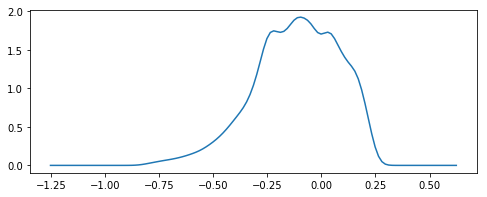

In [83]:
# detector plane
#deuxtheta = 0.9*deuxtheta
detector_position  = np.array((-rayon_gonio*np.cos(deuxtheta),
                              0,
                              +rayon_gonio*np.sin(deuxtheta)))
detector_normal = rt.normalize(np.array((+np.cos(deuxtheta),
                                  0,
                                  -np.sin(deuxtheta))))

detector_vertical = rt.normalize(np.array((0, 1, 0)))

detector_u, detector_v = rt.projection_detector_plane(B, d,
                                                   detector_position,
                                                   detector_normal,
                                                   detector_vertical)

detector_height = 20 # mm


mask = np.logical_and(detector_v<+detector_height/2,
                      detector_v>-detector_height/2)

# proj along 2theta
detected_2theta_deg = detector_u[mask]# / rayon_gonio *180/np.pi
detected_kde = gaussian_kde( detected_2theta_deg )


deux_theta_graph = np.linspace(1.5*np.min(detected_2theta_deg),
                               2.5*np.max(detected_2theta_deg), 121)
plt.figure(figsize=(8,3))
plt.plot(deux_theta_graph, detected_kde(deux_theta_graph));

# Graph
#plt.figure(figsize=(3,9))
#plt.plot(detector_u[mask], detector_v[mask], '.', alpha=0.2);
#plt.axis('equal'); plt.title('normal to the beam');


In [60]:
detector_height/2 / rayon_gonio

0.03125

In [86]:
1/4 *np.pi/180 * rayon_gonio

1.3962634015954636